In [ ]:
# !pip install --upgrade rioxarray
# !pip install --upgrade numpy
# !pip install --upgrade pandas
# !pip install --upgrade plotly
# !pip install --upgrade pyarrow
# !pip install --upgrade matplotlib
# !pip install --upgrade s2cloudless
# !pip install --upgrade pandas
# !pip install --upgrade black
# !pip install --upgrade pandas "dask[complete]"
# !pip install gdal
#!pip install --upgrade plotly
# !pip install --upgrade notebook --user
#!pip install jupyterlab-plotly

#!pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
#!pip install ipywidgets
# !pip install sentinelhub

In [1]:
import matplotlib.image as mpimg
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask
from matplotlib.colors import ListedColormap
from osgeo import gdal
import datetime as dt
import plotly.io as pio
import os
import copy
from datetime import datetime
import rasterio

## S2Cloudless

In [15]:
class ImageProcessing:
    # Valor padrão para pixels inválidos nas imagens
    INVALID_VALUE = -9999
    # Fator de escala para normalização dos valores das imagens
    RESCALE_FACTOR = 0.0001

    def __init__(self, pastas: str):
        # Listas para armazenar bandas e máscaras das imagens
        self.bands = []
        self.mask = []
        # Caminho para o diretório de imagens
        self.pastas = pastas
        # Indicador se os arquivos são do tipo TIF
        self._TIF = False
        # Lista de arquivos na pasta
        self._arquivos_na_pasta = self._pasta_arquivos(self.pastas)
        # Lista de datas disponíveis com suas respectivas bandas
        self.available_dates = self._available_dates(self._arquivos_na_pasta)

    def _pasta_arquivos(self, pasta):
        # Obter a lista de arquivos no diretório
        temp = os.listdir(pasta)
        # Remover pasta de checkpoints gerada pelo Jupyter, se existir
        temp.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in temp else ...
        # Filtrar arquivos que contenham 'TCI' no nome
        temp = [file for file in temp if 'TCI' not in file]
        
        if ".tif" in temp[0]:
            # Se os arquivos são do tipo TIF, ordenar por data
            self._TIF = True
            Sorted_temp = sorted(temp, key=lambda x: self._date_band(x))
            return Sorted_temp
        else:
            return temp

    def _date_band(self, file):
        # Extrair a data e a banda do nome do arquivo
        splitted = file.split('doy') if self._TIF else file.split('_', 2)
        if self._TIF:
            return [int(splitted[1][0:7]), splitted[0][11:14]]
        else:
            return [int(splitted[1][0:8]), splitted[2][0:3]]

    def _available_dates(self, arquivos_na_pasta):
        # Lista temporária para armazenar datas únicas e informações sobre bandas associadas
        temp = []
        # Lista final para armazenar datas disponíveis e suas respectivas bandas
        available = []
        for file in arquivos_na_pasta:
            date, band = self._date_band(file)
            # Ignora datas já processadas
            if date in temp:
                continue

            # Lista de datas e bandas associadas à data
            date_list = [date for item in arquivos_na_pasta if f'{date}' in item]
            band_list = [item for item in arquivos_na_pasta if f'{date}' in item]
            temp.append(date)

            # Verifica se há 13 bandas para uma data específica
            if (len(date_list) == 13) or (len(date_list[:-1]) == 13):
                # Adiciona a data e suas bandas únicas à lista final
                if not ([set(date_list), band_list] in available):
                    available.append([list(set(date_list)), sorted(list(set(band_list)))])
        return copy.deepcopy(available)


    def _get_another_band(self, datas):
        # Itera sobre as datas disponíveis e chama o método get_day_img
        for conjunto in datas:
            data = conjunto[0]
            self.get_day_img(data)
            yield data
            
            
    def getBands(self):
        for data in self._get_another_band(self.available_dates):
            # Transformar as bandas em um array tridimensional
            bands_shapes = [band.shape for band in self.bands]
            bands_array = np.transpose(np.array(self.bands), (2, 1, 0))
            yield bands_array

    @staticmethod
    def s2cloudless(banda, threshold=0.4, average_core=4, dilation_size=2, all_bands=True) -> list:
        """threshold - cloud probability threshold value. All pixels with cloud probability above threshold value are masked as cloudy pixels. Default is 0.4.
            average_over - Size of the disk in pixels for performing convolution (averaging probability over pixels). For this resolution 4 is appropriate.
            dilation_size - Size of the disk in pixels for performing dilation. For this resolution 2 is appropriate.
            all_bands - Flag specifying that input images will consists of all 13 Sentinel-2 bands. It has to be set to True if we would download all bands. If you define a layer that would return only 10 bands, then this parameter should be set to False."""
        # Método estático para aplicar o detector de nuvens s2cloudless
        cloud_detector = S2PixelCloudDetector(threshold=threshold, average_over=average_core, dilation_size=dilation_size, all_bands=all_bands)
        cloud_prob = cloud_detector.get_cloud_probability_maps(banda[np.newaxis, ...])
        cloud_mask = cloud_detector.get_cloud_masks(banda[np.newaxis, ...])
        return [cloud_prob, cloud_mask]

    def get_day_img(self, data: str) -> None:
        # Obtém as bandas e a máscara associadas a uma data específica
        arquivos = next((conjunto[1] for conjunto in self.available_dates if data in conjunto), None)
        if arquivos is not None:
            # Obtém o índice da banda 'b08', se presente
            b08_index = next((arquivos.index(item) for item in arquivos if "b08" in item.lower()), None)
            for arquivo in arquivos:
                # Constrói o caminho completo para o arquivo de imagem
                caminho_imagem_arquivo = f'{self.pastas}{arquivo}'
                # Verifica se o arquivo representa a banda 'b8a' ou é uma máscara
                b8a_test = "b8a" in arquivo.lower()
                mask_test = "fmask" in arquivo.lower()
                # Lê os dados da imagem usando a biblioteca rasterio
                img_data = rasterio.open(caminho_imagem_arquivo).read(1).astype(float)
                # Substitui valores inválidos por 0 e aplica o fator de escala
                img_data[img_data == ImageProcessing.INVALID_VALUE] = 0
                img_data *= ImageProcessing.RESCALE_FACTOR
                if b8a_test and b08_index:
                    # Insere a banda 'b8a' na posição correta
                    index = b08_index + 1
                    self.bands.insert(index, img_data)
                else:
                    self.mask.append(img_data) if mask_test else self.bands.append(img_data)


In [ ]:
os.listdir('./pasta/L1C_IMAGEM_1')

In [2]:
# Lista para armazenar as bandas da imagem

imagens = []

pastas = os.listdir('./pasta')
pastas.remove('.ipynb_checkpoints')


# Loop sobre as 13 bandas da imagem Sentinel-2
for pasta in pastas:
    bandas = []
    L1C_IMG = os.listdir(f'./pasta/{pasta}')
    L1C_IMG.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in L1C_IMG else ...
    L1C_IMG = L1C_IMG[2]
    print(L1C_IMG)
    for i in range(1, 14):
        # Constrói o caminho completo para o arquivo de imagem da banda específica
        banda_i = rasterio.open(f'pasta/{pasta}/{L1C_IMG}').read(i).astype(np.float32) * 0.0001 # 60 m de resolução (subset = 0 (60m) )
        # Normaliza os valores da banda dividindo por 10000 (processamento exigido pela documentação do S2Cloudless)
        # Adiciona a banda à lista de bandas
        bandas.append(banda_i)
    bands_array = np.stack(bandas, axis=-1)
    imagens.append(bands_array)

print(imagens[0].shape)

subset_0_of_S2B_MSIL1C_20220705T135709_N0400_R067_T21MYS_20220705T172624_resampled.tif
subset_0_of_S2A_MSIL1C_20230918T144731_N0509_R139_T19LGL_20230918T180815_resampled.tif
subset_0_of_S2B_MSIL1C_20230604T151709_N0509_R125_T18MXA_20230604T181707_resampled.tif
subset_0_of_S2B_MSIL1C_20231010T143729_N0509_R096_T20MMC_20231010T180007_resampled.tif
(1830, 1830, 13)


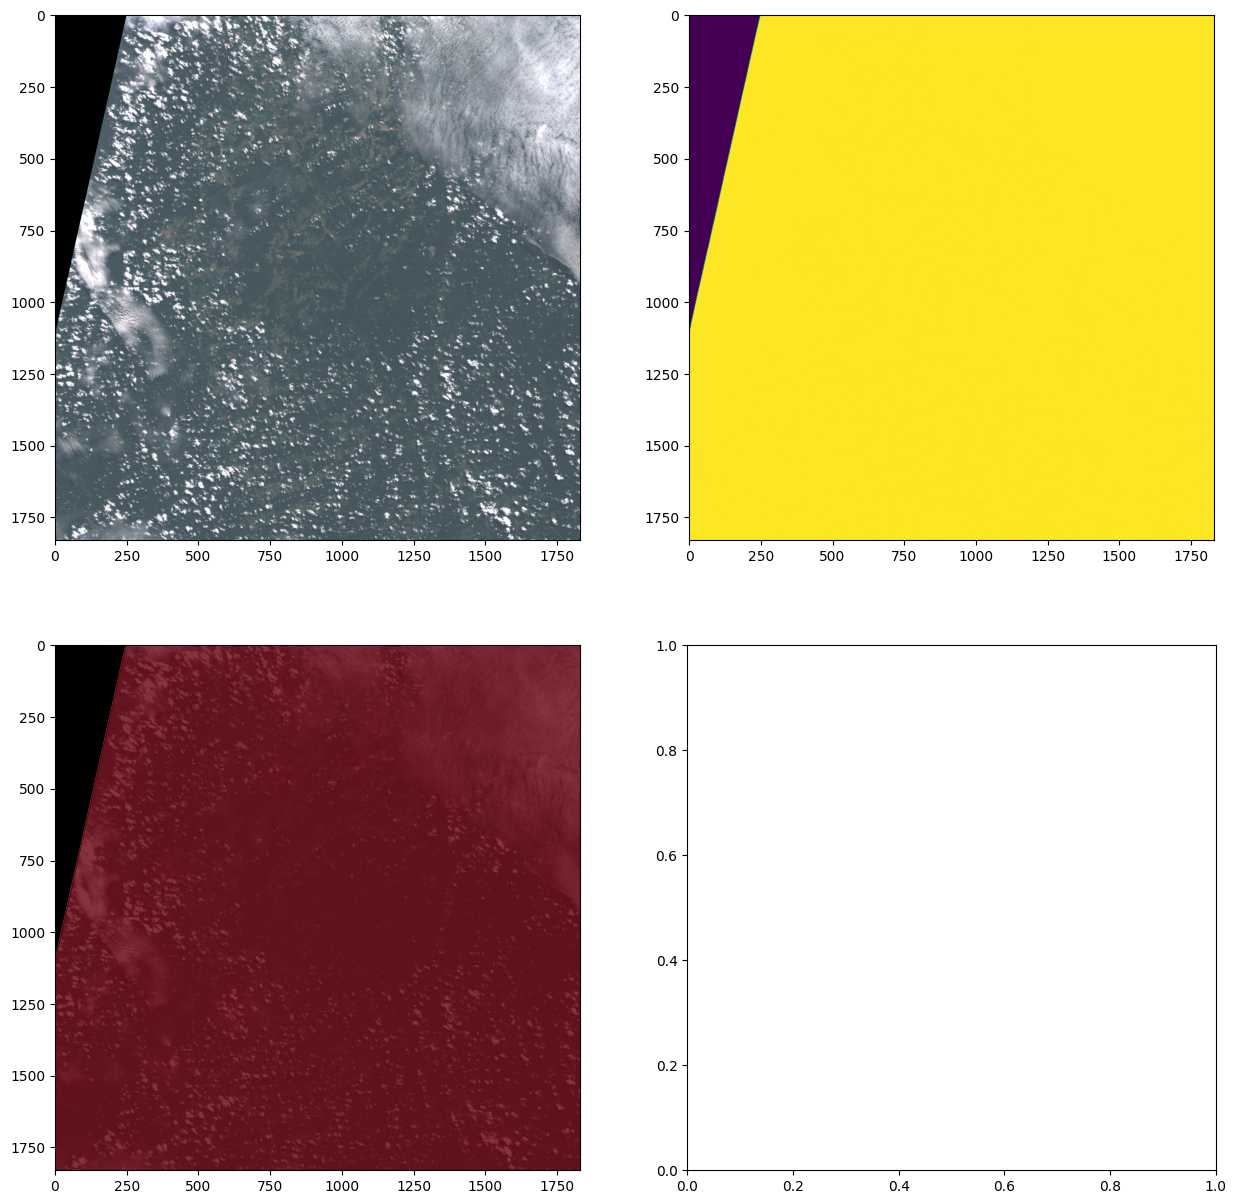

In [16]:
cloud_prob, cloud_mask = ImageProcessing.s2cloudless(imagens[0],threshold=0.4, average_core=4, dilation_size=2)

# Cria uma imagem de cor verdadeira (true color) combinando as bandas 3, 2, e 1 (R,G,B)
true_color_image = (imagens[0][..., [3, 2, 1]] * 2).clip(0, 1)

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax[0][0].imshow(true_color_image)
ax[0][1].imshow(cloud_prob[0])
ax[1][0].imshow(true_color_image, cmap='Reds')
ax[1][0].imshow(cloud_mask[0], alpha=0.8 * cloud_mask[0], cmap='Reds')

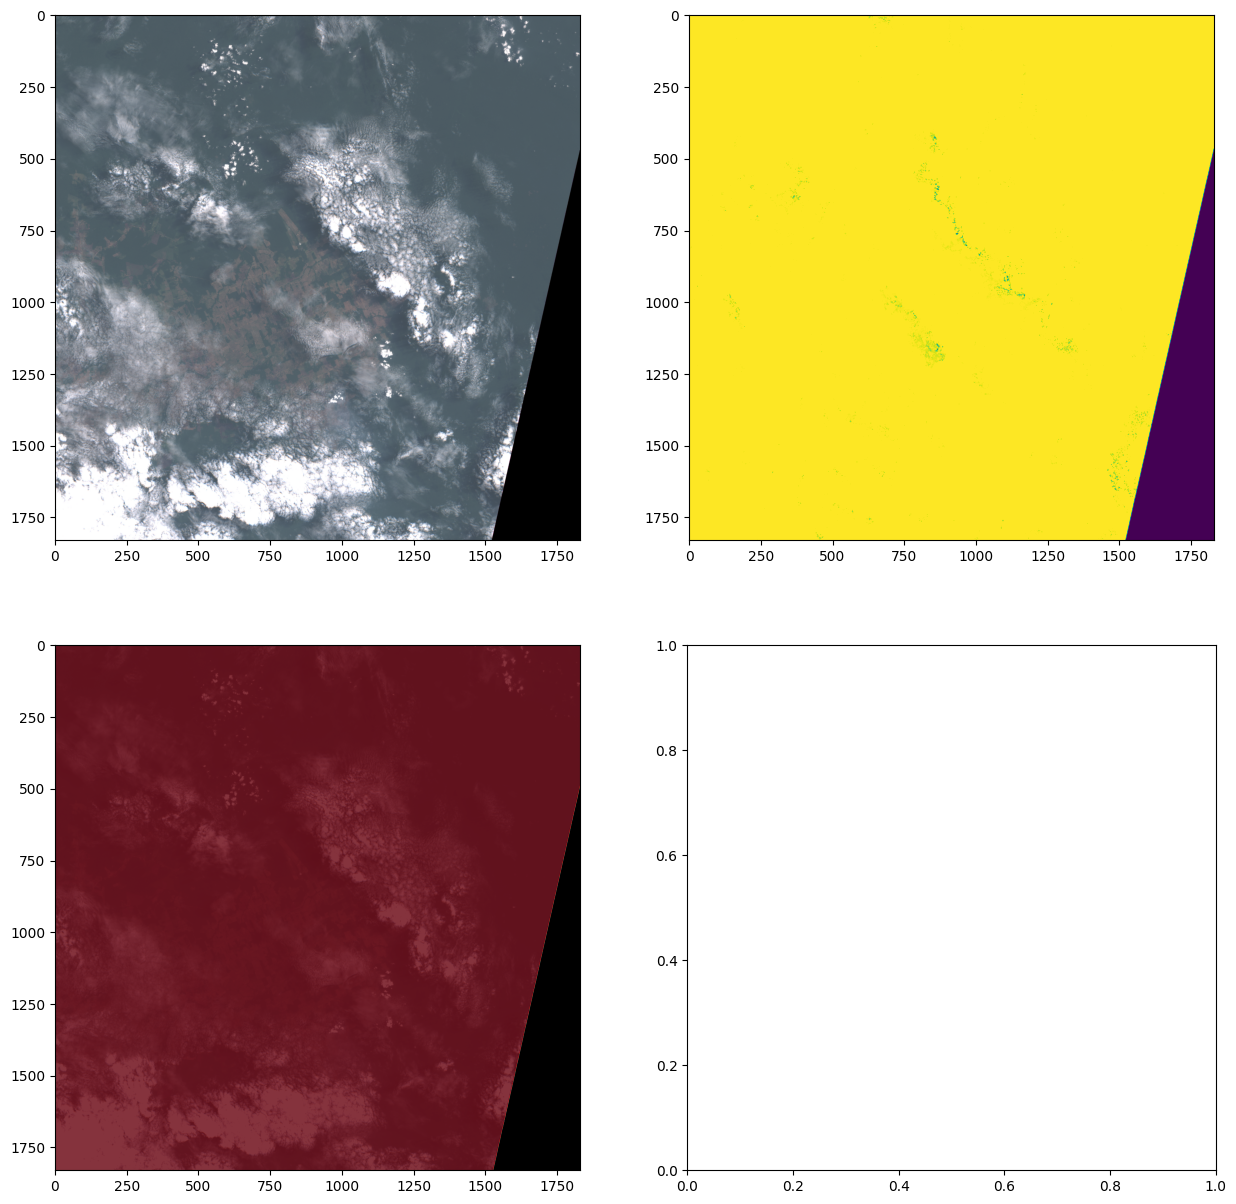

In [17]:
cloud_prob, cloud_mask = ImageProcessing.s2cloudless(imagens[1],threshold=0.4, average_core=4, dilation_size=2)

# Cria uma imagem de cor verdadeira (true color) combinando as bandas 3, 2, e 1 (R,G,B)
true_color_image = (imagens[1][..., [3, 2, 1]] * 2).clip(0, 1)

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax[0][0].imshow(true_color_image)
ax[0][1].imshow(cloud_prob[0])
ax[1][0].imshow(true_color_image, cmap='Reds')
ax[1][0].imshow(cloud_mask[0], alpha=0.8 * cloud_mask[0], cmap='Reds')

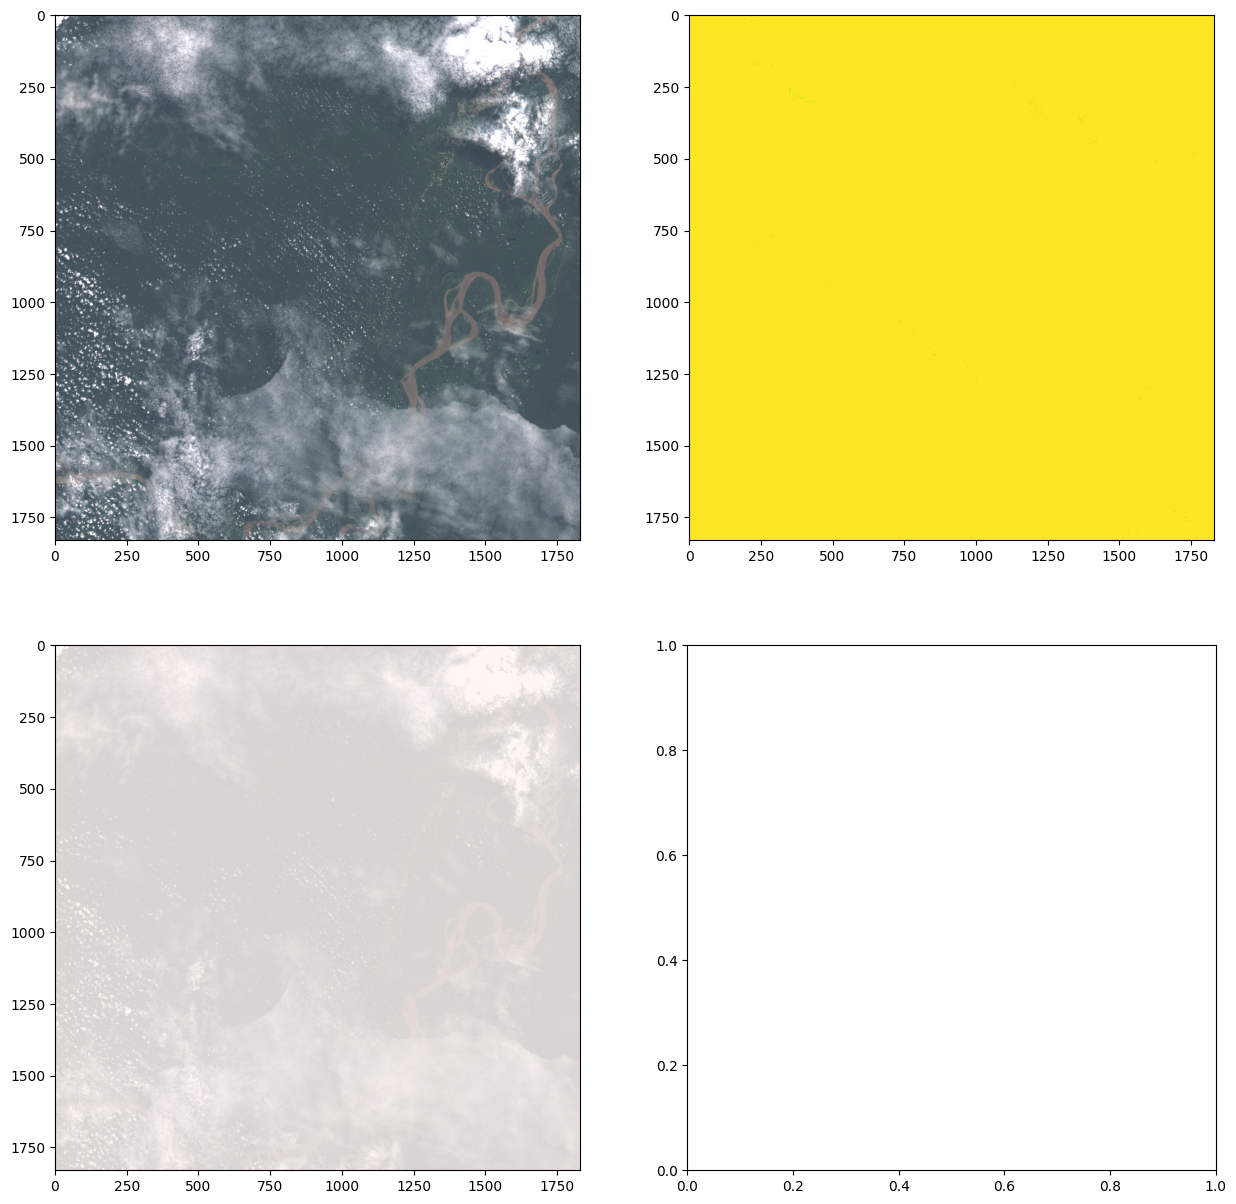

In [18]:
cloud_prob, cloud_mask = ImageProcessing.s2cloudless(imagens[2],threshold=0.4, average_core=4, dilation_size=2)

# Cria uma imagem de cor verdadeira (true color) combinando as bandas 3, 2, e 1 (R,G,B)
true_color_image = (imagens[2][..., [3, 2, 1]] * 2).clip(0, 1)

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax[0][0].imshow(true_color_image)
ax[0][1].imshow(cloud_prob[0])
ax[1][0].imshow(true_color_image, cmap='Reds')
ax[1][0].imshow(cloud_mask[0], alpha=0.8 * cloud_mask[0], cmap='Reds')

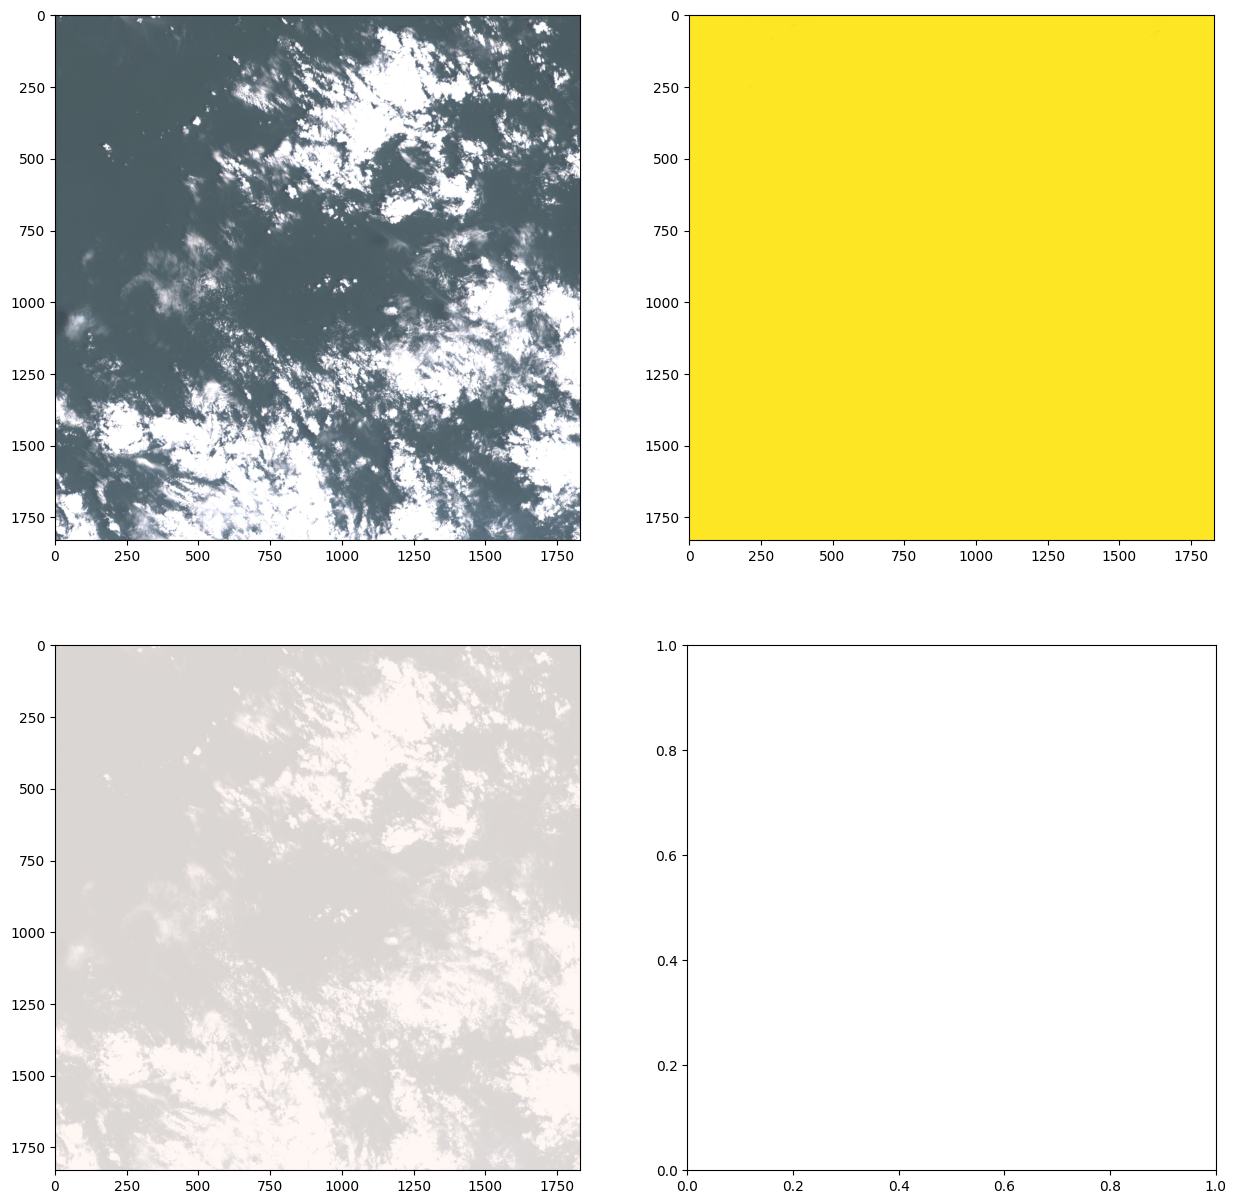

In [19]:
cloud_prob, cloud_mask = ImageProcessing.s2cloudless(imagens[3],threshold=0.4, average_core=4, dilation_size=2)

# Cria uma imagem de cor verdadeira (true color) combinando as bandas 3, 2, e 1 (R,G,B)
true_color_image = (imagens[3][..., [3, 2, 1]] * 2).clip(0, 1)

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax[0][0].imshow(true_color_image)
ax[0][1].imshow(cloud_prob[0])
ax[1][0].imshow(true_color_image, cmap='Reds')
ax[1][0].imshow(cloud_mask[0], alpha=0.8 * cloud_mask[0], cmap='Reds')

## Fmask

In [3]:
# Lista para armazenar as bandas da imagem

fmask_imgs = []
real_img = []

pastas = os.listdir('./pasta')
pastas.remove('.ipynb_checkpoints')

# Loop sobre as 13 bandas da imagem Sentinel-2
for pasta in pastas:
    bandas = []
    L1C_PASTA = os.listdir(f'./pasta/{pasta}')

    L1C_PASTA.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in L1C_PASTA else ...
    L1C_PASTA = L1C_PASTA[1]

    IMG_PATH = f'./pasta/{pasta}/{L1C_PASTA}/'
    IMG_DIR = os.listdir(IMG_PATH)
    
    REAL_IMG = [i for i in IMG_DIR if ".jpg" in i]
    real_img.append(f'{IMG_PATH}{REAL_IMG[0]}')
    
    L1C_IMG_PASTA = os.listdir(f'./pasta/{pasta}/{L1C_PASTA}/GRANULE/')
    FMASK_PASTA = os.listdir(f'./pasta/{pasta}/{L1C_PASTA}/GRANULE/{L1C_IMG_PASTA[0]}/FMASK_DATA')
    data = rasterio.open(f'./pasta/{pasta}/{L1C_PASTA}/GRANULE/{L1C_IMG_PASTA[0]}/FMASK_DATA/{FMASK_PASTA[0]}').read(1)
    data[data == 255] = 5
    fmask_imgs.append(data)

print(fmask_imgs[0].shape)

(5490, 5490)


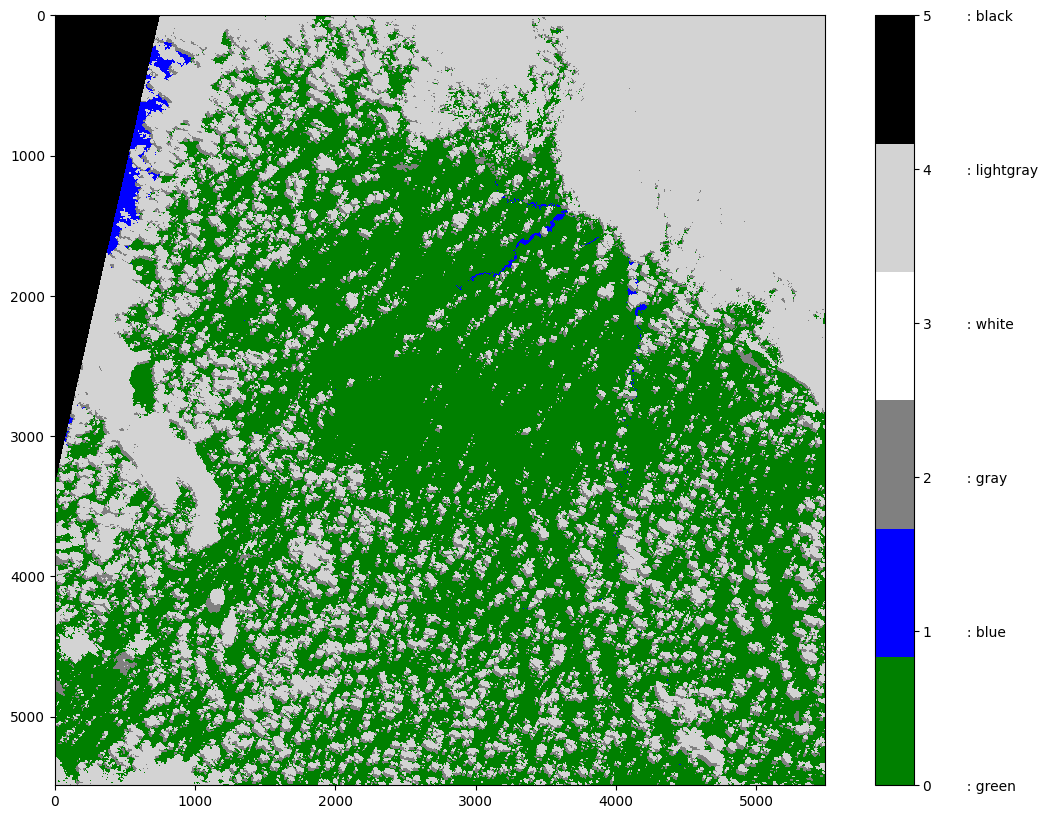

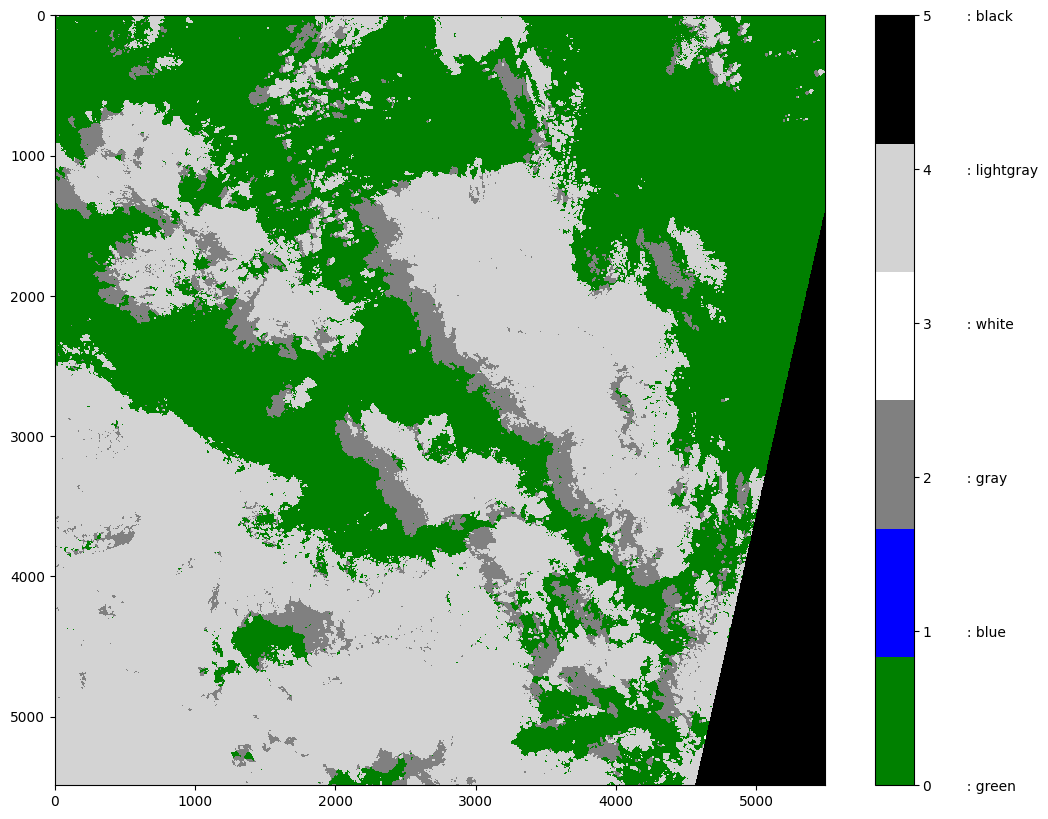

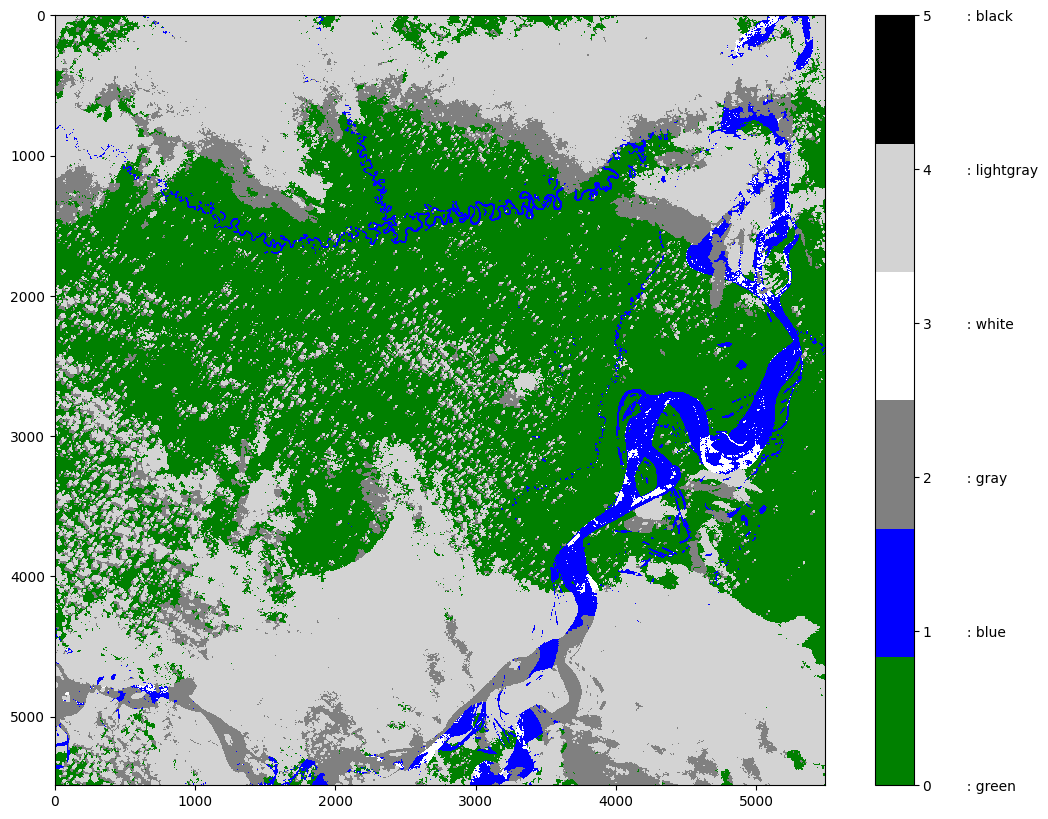

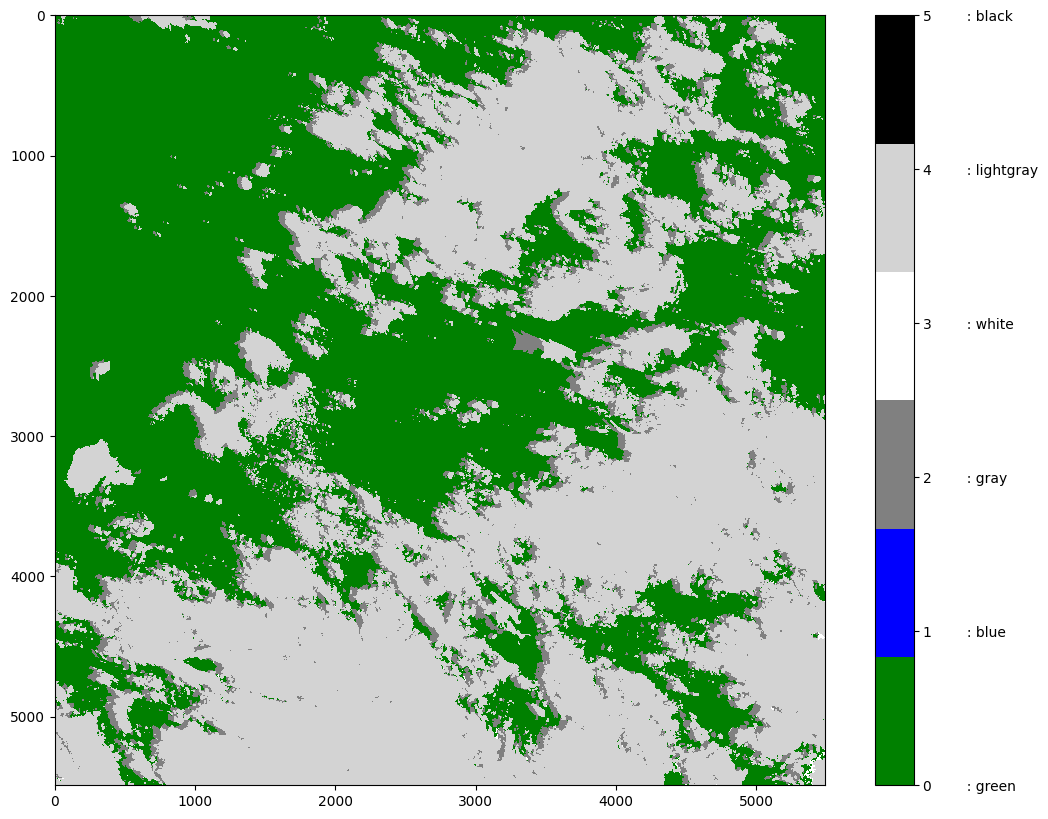

In [4]:
# Dicionário de cores associadas aos valores da máscara
colors = {
    0: 'green',        # Terra sem nuvens
    1: 'blue',         # Água sem nuvens
    2: 'gray',         # Sombra de nuvem
    3: 'white',        # Neve
    4: 'lightgray',    # Nuvem
    5: 'black'         # Sem observação
}
for img in fmask_imgs:
    # Substitui valores 255 por 5 para representar "sem observação"
    data[data == 255] = 5 
    
    max_color_len = max(len(color) for color in colors.values())
    # Encontra o comprimento máximo entre os nomes das cores
    
    # Cria uma lista de cores para a visualização usando Matplotlib
    cmap = ListedColormap([colors[i] for i in colors])
    
    # Ajusta o tamanho da figura para melhor visualização
    plt.figure(figsize=(13, 10))
    
    # Exibe a visualização da máscara de classificação de nuvens usando Matplotlib
    plt.imshow(img, cmap=cmap, interpolation='none', vmin=0, vmax=max(colors))
    plt.colorbar(ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {colors[x]}")
    plt.show()

In [24]:
kappa_imgs = []

pastas = os.listdir('./pasta')
pastas.remove('.ipynb_checkpoints')

for pasta in pastas:
    bandas = []
    L1C_PASTA = os.listdir(f'./pasta/{pasta}/kappa_output')
    L1C_PASTA.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in L1C_PASTA else ...
    data = os.listdir(f'./pasta/{pasta}/kappa_output/')
    data.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in data else ...
    kappa_imgs.append(f'./pasta/{pasta}/kappa_output/{data[0]}')

print(kappa_imgs[0])

./pasta/L1C_IMAGEM_1/kappa_output/L1C_T21MYS_20220705T135709_KZ_10m.png


In [12]:
kappa_imgs[0]

<open DatasetReader name='./pasta/L1C_IMAGEM_1/kappa_output/L1C_T21MYS_20220705T135709_KZ_10m.tif' mode='r'>

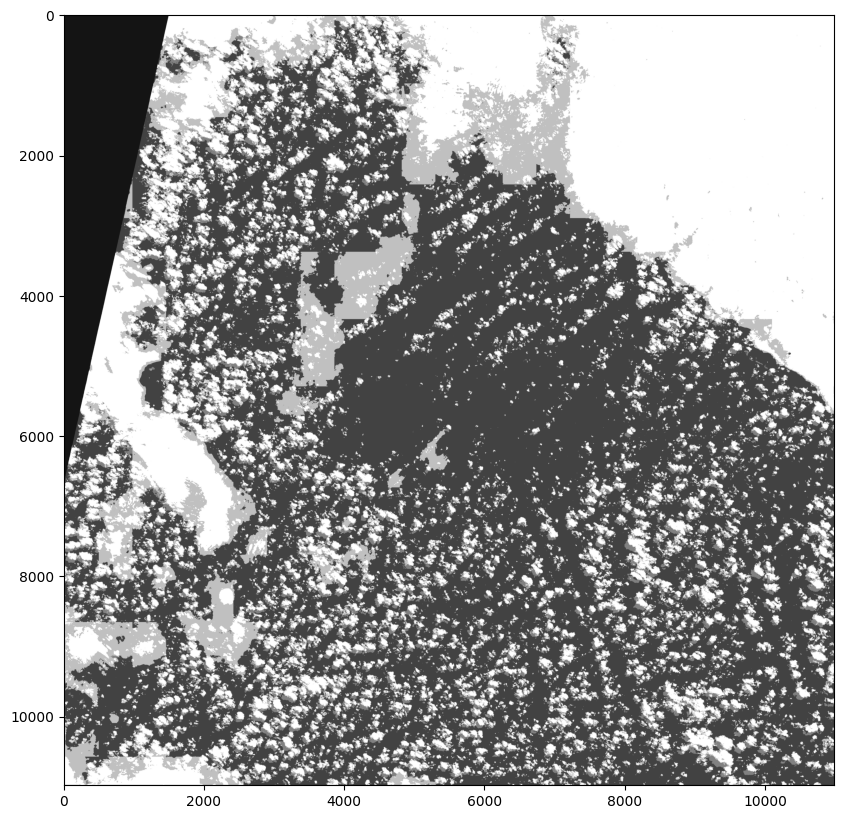

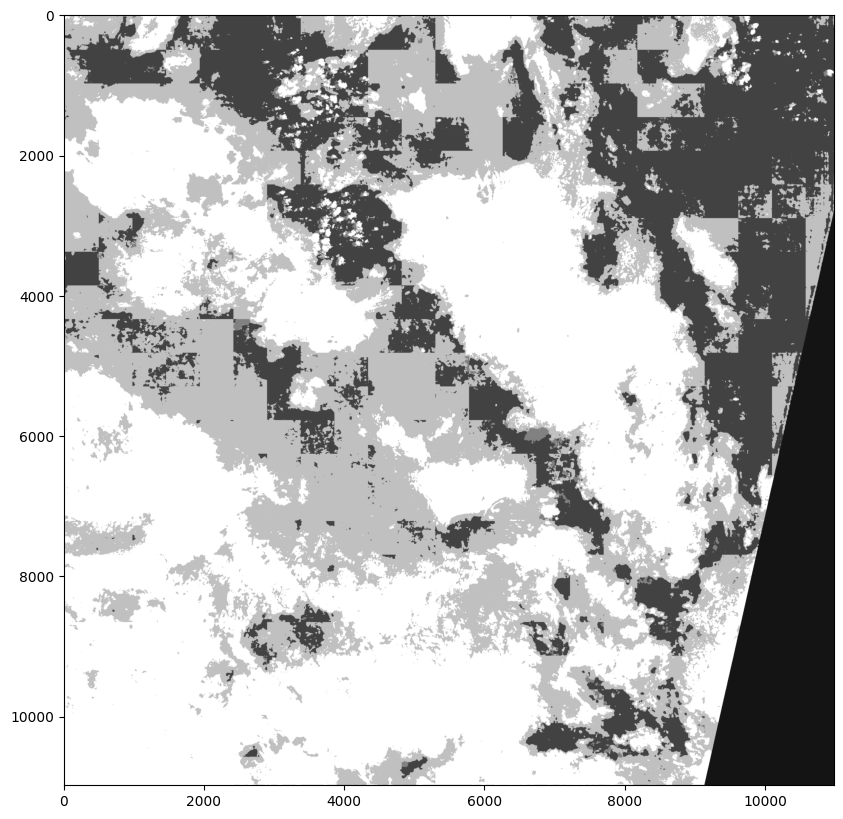

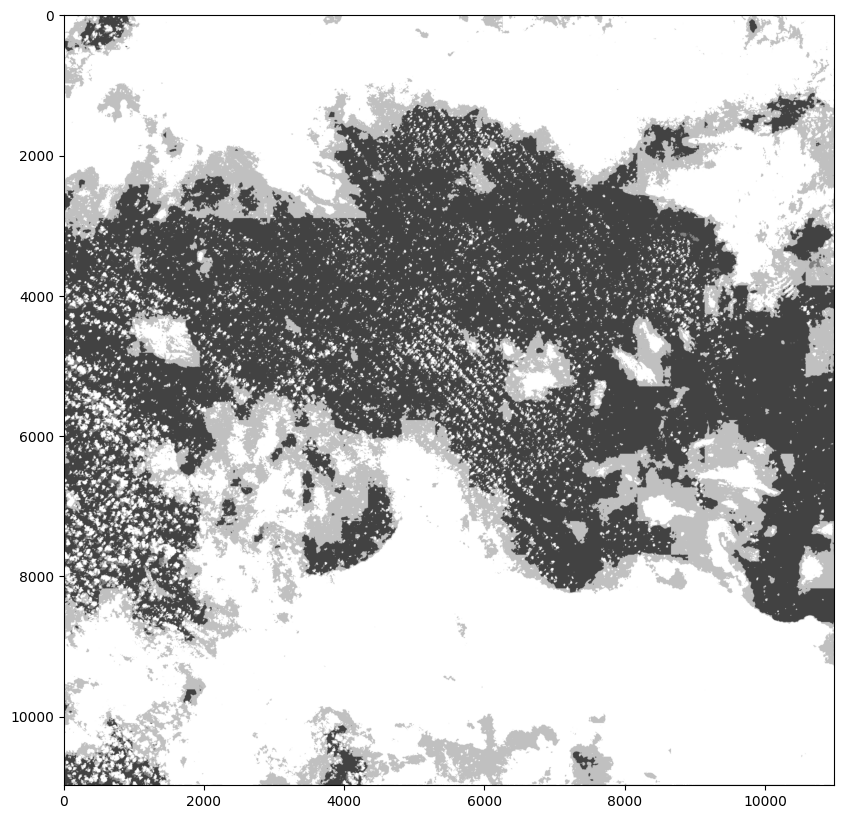

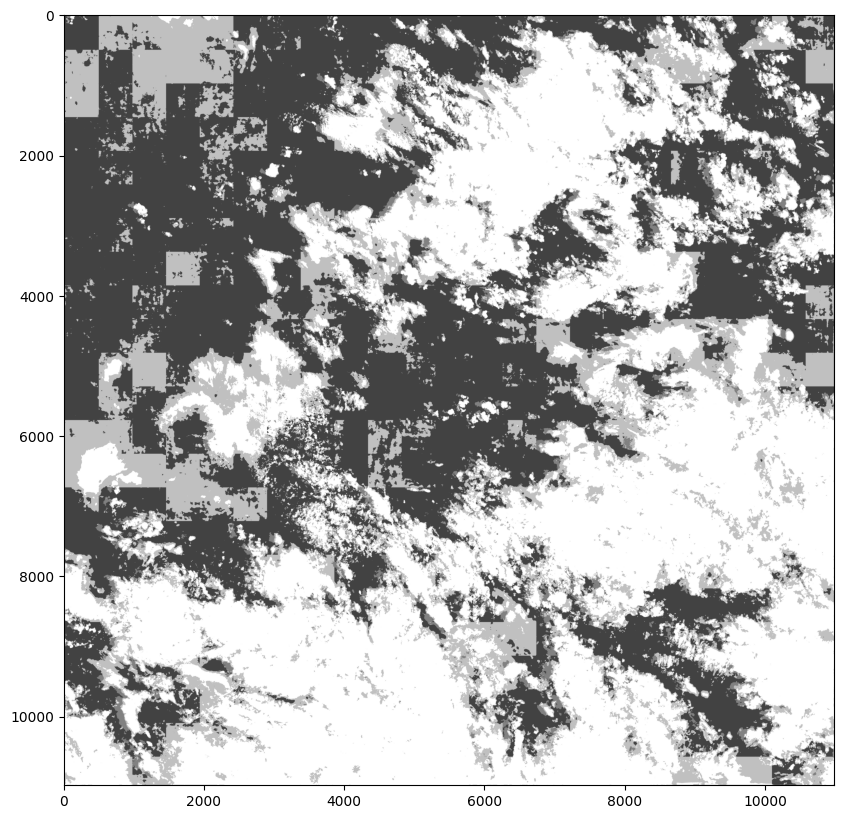

In [25]:
for img in kappa_imgs:
    true_img = plt.imread(img)
    plt.figure(figsize=(13, 10))
    imgplot = plt.imshow(true_img)
    plt.show()

In [29]:
kappa_imgs = []

pastas = os.listdir('./pasta')
pastas.remove('.ipynb_checkpoints')

for pasta in pastas:
    bandas = []
    L1C_PASTA = os.listdir(f'./pasta/{pasta}/kappa_output')
    L1C_PASTA.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in L1C_PASTA else ...
    data = os.listdir(f'./pasta/{pasta}/kappa_output/')
    data.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in data else ...
    data = rasterio.open(f'./pasta/{pasta}/kappa_output/{data[1]}').read(1)
    kappa_imgs.append(data)

print(kappa_imgs[0])

[[5 5 5 ... 4 4 4]
 [5 5 5 ... 4 4 4]
 [5 5 5 ... 4 4 4]
 ...
 [4 4 4 ... 1 1 5]
 [4 4 4 ... 1 5 5]
 [5 5 5 ... 5 5 5]]


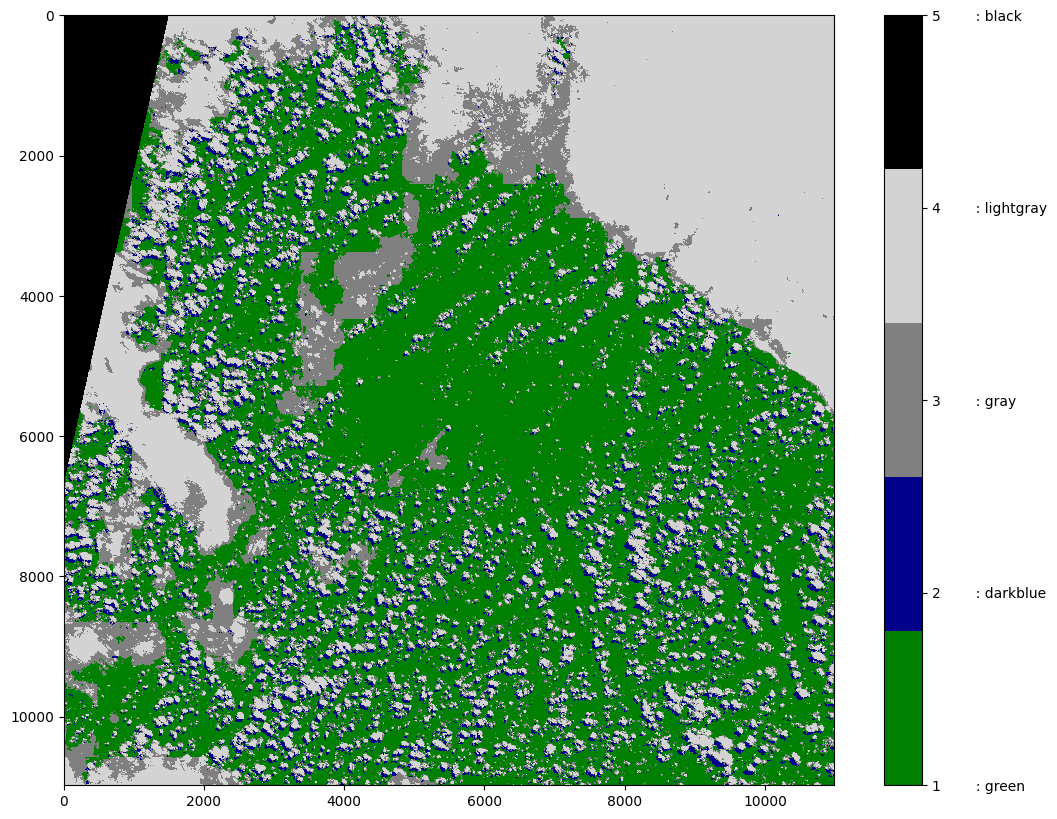

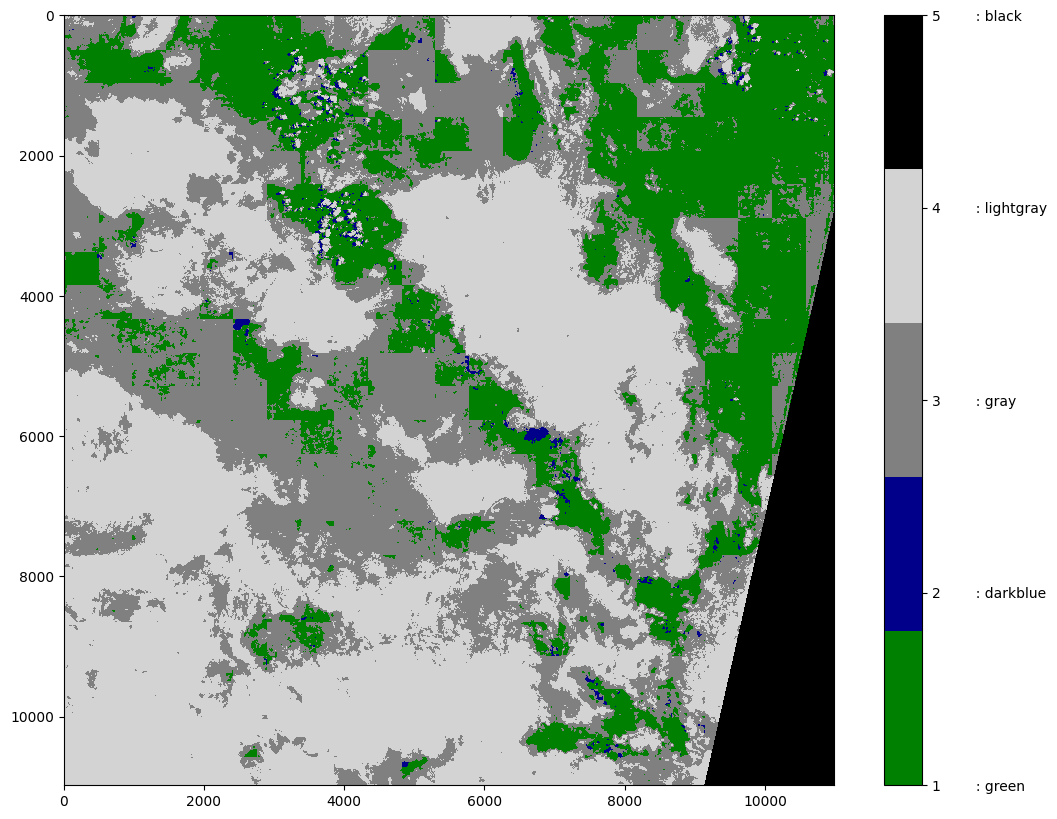

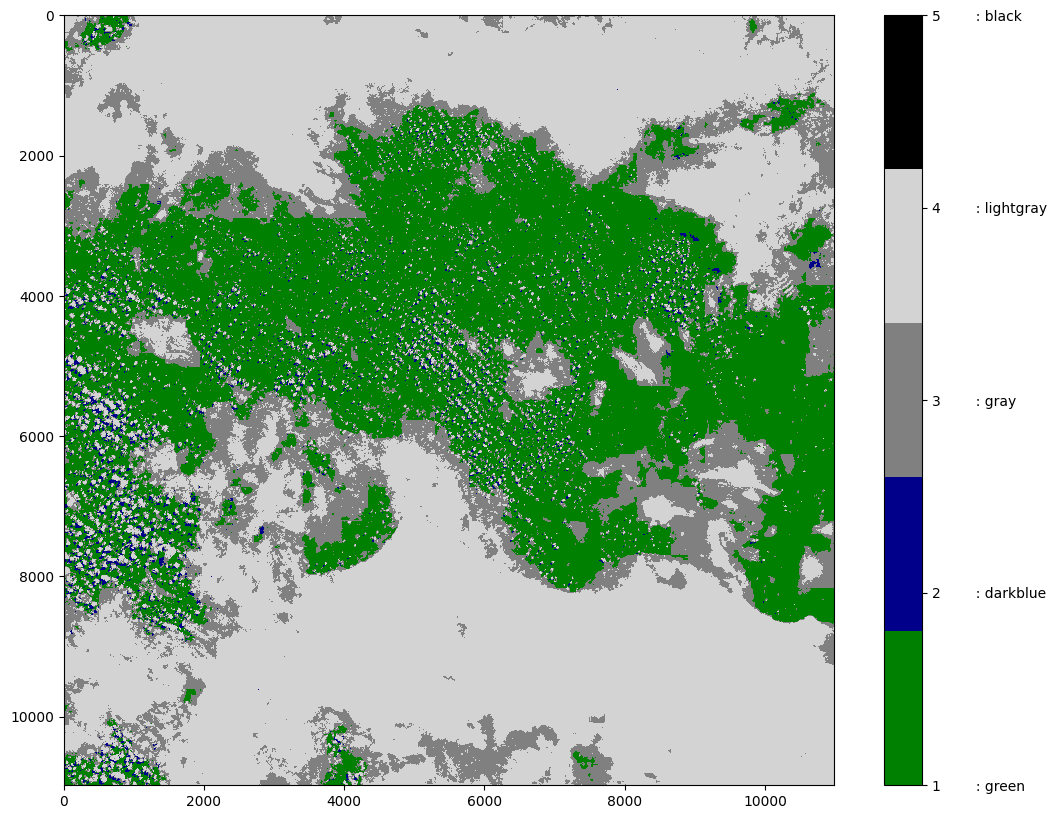

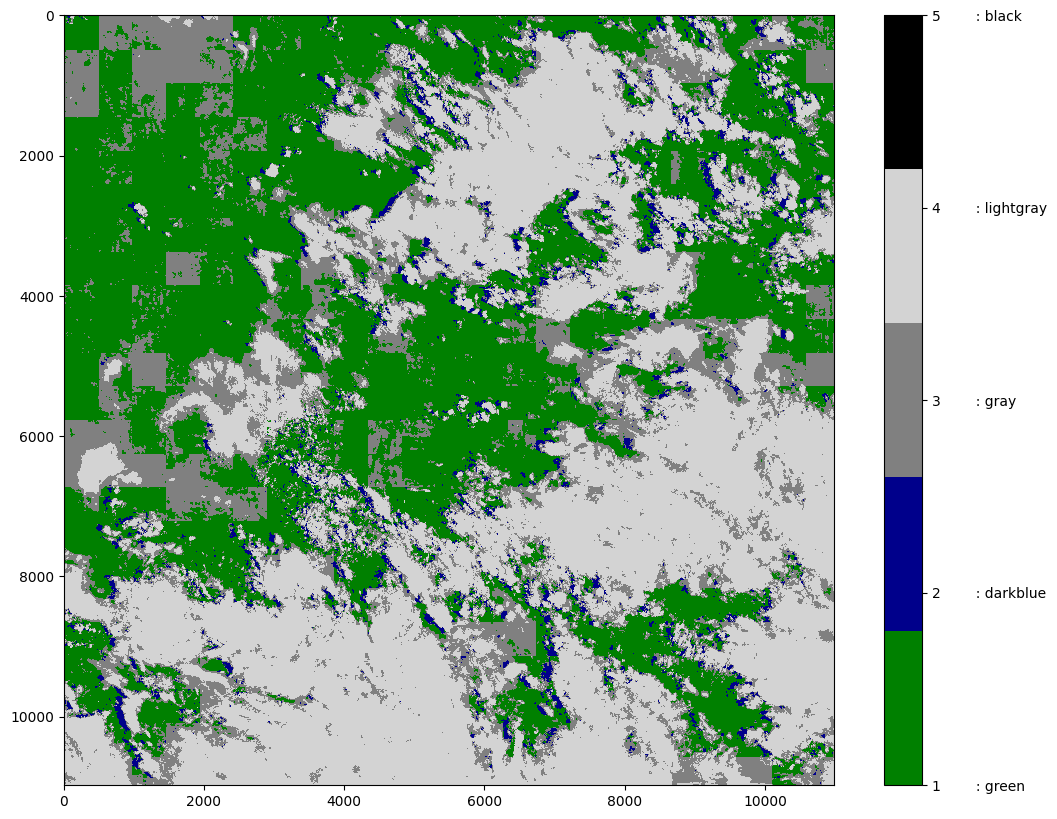

In [34]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Dicionário de cores associadas aos valores da máscara
colors = {
    1: 'green',             # Clear
    2: 'darkblue',          # Cloud shadow
    3: 'gray',              # Semi-transparent
    4: 'lightgray',         # Cloud
    5: 'black'              # Missing
}

# Substitui valores 255 por 5 para representar "Missing"
for img in kappa_imgs:
    img[img == 255] = 5

    max_color_len = max(len(color) for color in colors.values())
    # Encontra o comprimento máximo entre os nomes das cores
    
    # Cria uma lista de cores para a visualização usando Matplotlib
    cmap = ListedColormap([colors[i] for i in colors])
    
    # Ajusta o tamanho da figura para melhor visualização
    plt.figure(figsize=(13, 10))
    
    # Exibe a visualização da máscara de classificação de nuvens usando Matplotlib
    plt.imshow(img, cmap=cmap, interpolation='none', vmin=min(colors), vmax=max(colors))
    plt.colorbar(ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {colors[x]}")
    
    plt.show()


# Testes Antigos

## S2cloudless SANTAREM TORRE

In [ ]:
class ImageProcessing:
    # Valor padrão para pixels inválidos nas imagens
    INVALID_VALUE = -9999
    # Fator de escala para normalização dos valores das imagens
    RESCALE_FACTOR = 0.0001

    def __init__(self, pastas: str):
        # Listas para armazenar bandas e máscaras das imagens
        self.bands = []
        self.mask = []
        # Caminho para o diretório de imagens
        self.pastas = pastas
        # Indicador se os arquivos são do tipo TIF
        self._TIF = False
        # Lista de arquivos na pasta
        self._arquivos_na_pasta = self._pasta_arquivos(self.pastas)
        # Lista de datas disponíveis com suas respectivas bandas
        self.available_dates = self._available_dates(self._arquivos_na_pasta)

    def _pasta_arquivos(self, pasta):
        # Obter a lista de arquivos no diretório
        temp = os.listdir(pasta)
        # Remover pasta de checkpoints gerada pelo Jupyter, se existir
        temp.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in temp else ...
        # Filtrar arquivos que contenham 'TCI' no nome
        temp = [file for file in temp if 'TCI' not in file]
        
        if ".tif" in temp[0]:
            # Se os arquivos são do tipo TIF, ordenar por data
            self._TIF = True
            Sorted_temp = sorted(temp, key=lambda x: self._date_band(x))
            return Sorted_temp
        else:
            return temp

    def _date_band(self, file):
        # Extrair a data e a banda do nome do arquivo
        splitted = file.split('doy') if self._TIF else file.split('_', 2)
        if self._TIF:
            return [int(splitted[1][0:7]), splitted[0][11:14]]
        else:
            return [int(splitted[1][0:8]), splitted[2][0:3]]

    def _available_dates(self, arquivos_na_pasta):
        # Lista temporária para armazenar datas únicas e informações sobre bandas associadas
        temp = []
        # Lista final para armazenar datas disponíveis e suas respectivas bandas
        available = []
        for file in arquivos_na_pasta:
            date, band = self._date_band(file)
            # Ignora datas já processadas
            if date in temp:
                continue

            # Lista de datas e bandas associadas à data
            date_list = [date for item in arquivos_na_pasta if f'{date}' in item]
            band_list = [item for item in arquivos_na_pasta if f'{date}' in item]
            temp.append(date)

            # Verifica se há 13 bandas para uma data específica
            if (len(date_list) == 13) or (len(date_list[:-1]) == 13):
                # Adiciona a data e suas bandas únicas à lista final
                if not ([set(date_list), band_list] in available):
                    available.append([list(set(date_list)), sorted(list(set(band_list)))])
        return copy.deepcopy(available)


    def _get_another_band(self, datas):
        # Itera sobre as datas disponíveis e chama o método get_day_img
        for conjunto in datas:
            data = conjunto[0]
            self.get_day_img(data)
            yield data
            
            
    def getBands(self):
        for data in self._get_another_band(self.available_dates):
            # Transformar as bandas em um array tridimensional
            bands_shapes = [band.shape for band in self.bands]
            bands_array = np.transpose(np.array(self.bands), (2, 1, 0))
            yield bands_array

    @staticmethod
    def s2cloudless(banda, threshold=0.4, average_core=4, dilation_size=2, all_bands=True) -> list:
        """threshold - cloud probability threshold value. All pixels with cloud probability above threshold value are masked as cloudy pixels. Default is 0.4.
            average_over - Size of the disk in pixels for performing convolution (averaging probability over pixels). For this resolution 4 is appropriate.
            dilation_size - Size of the disk in pixels for performing dilation. For this resolution 2 is appropriate.
            all_bands - Flag specifying that input images will consists of all 13 Sentinel-2 bands. It has to be set to True if we would download all bands. If you define a layer that would return only 10 bands, then this parameter should be set to False."""
        # Método estático para aplicar o detector de nuvens s2cloudless
        cloud_detector = S2PixelCloudDetector(threshold=threshold, average_over=average_core, dilation_size=dilation_size, all_bands=all_bands)
        cloud_prob = cloud_detector.get_cloud_probability_maps(banda[np.newaxis, ...])
        cloud_mask = cloud_detector.get_cloud_masks(banda[np.newaxis, ...])
        return [cloud_prob, cloud_mask]

    def get_day_img(self, data: str) -> None:
        # Obtém as bandas e a máscara associadas a uma data específica
        arquivos = next((conjunto[1] for conjunto in self.available_dates if data in conjunto), None)
        if arquivos is not None:
            # Obtém o índice da banda 'b08', se presente
            b08_index = next((arquivos.index(item) for item in arquivos if "b08" in item.lower()), None)
            for arquivo in arquivos:
                # Constrói o caminho completo para o arquivo de imagem
                caminho_imagem_arquivo = f'{self.pastas}{arquivo}'
                # Verifica se o arquivo representa a banda 'b8a' ou é uma máscara
                b8a_test = "b8a" in arquivo.lower()
                mask_test = "fmask" in arquivo.lower()
                # Lê os dados da imagem usando a biblioteca rasterio
                img_data = rasterio.open(caminho_imagem_arquivo).read(1).astype(float)
                # Substitui valores inválidos por 0 e aplica o fator de escala
                img_data[img_data == ImageProcessing.INVALID_VALUE] = 0
                img_data *= ImageProcessing.RESCALE_FACTOR
                if b8a_test and b08_index:
                    # Insere a banda 'b8a' na posição correta
                    index = b08_index + 1
                    self.bands.insert(index, img_data)
                else:
                    self.mask.append(img_data) if mask_test else self.bands.append(img_data)


In [ ]:
# Lista para armazenar as bandas da imagem
bandas = []

# Loop sobre as 13 bandas da imagem Sentinel-2
for i in range(1, 14):
    # Constrói o caminho completo para o arquivo de imagem da banda específica
    banda_i = rasterio.open('SUBSET+SAFE/subset_1_of_S2B_MSIL1C_20220705T135709_N0400_R067_T21MYS_20220705T172624_resampled.tif').read(i) / 10000 # 60 m de resolução (subset = 0 (20 m), subset = 1 (60m) )
    # Normaliza os valores da banda dividindo por 10000 (processamento exigido pela documentação do S2Cloudless)
    # Adiciona a banda à lista de bandas
    bandas.append(banda_i)

# Converte a lista de bandas em um array tridimensional
bands_array = np.stack(bandas, axis=-1)

# Imprime a forma (shape) do array resultante
print(bands_array.shape)

In [ ]:
cloud_prob, cloud_mask = ImageProcessing.s2cloudless(bands_array,threshold=0.8, average_core=4, dilation_size=2)

In [ ]:
# Cria uma imagem de cor verdadeira (true color) combinando as bandas 3, 2, e 1 (R,G,B)
true_color_image = (bands_array[..., [3, 2, 1]] * 2).clip(0, 1)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(true_color_image)
ax[1].imshow(cloud_prob[0])

In [ ]:
true_color_image = (bands_array[..., [3, 2, 1]] * 2).clip(0, 1)
is_cloud = cloud_mask[0]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.imshow(true_color_image)
ax.imshow(is_cloud, alpha=0.8 * is_cloud, cmap='Reds')

## FMASK SANTAREM TORRE

In [ ]:
# OBS: Não fiz o código abaixo
# Lê os dados da máscara de classificação de nuvens (Fmask) a partir do arquivo TIFF
data = rasterio.open('SUBSET+SAFE\S2B_MSIL1C_20220705T135709_N0400_R067_T21MYS_20220705T172624.SAFE\GRANULE\L1C_T21MYS_A027835_20220705T135807\FMASK_DATA\L1C_T21MYS_A027835_20220705T135807_Fmask4.tif').read(1)

# Substitui valores 255 por 5 para representar "sem observação"
data[data == 255] = 5 

# Dicionário de cores associadas aos valores da máscara
colors = {
    0: 'green',        # Terra sem nuvens
    1: 'blue',         # Água sem nuvens
    2: 'gray',         # Sombra de nuvem
    3: 'white',        # Neve
    4: 'lightgray',    # Nuvem
    5: 'black'         # Sem observação
}

# Encontra o comprimento máximo entre os nomes das cores
max_color_len = max(len(color) for color in colors.values())

# Cria uma lista de cores para a visualização usando Matplotlib
cmap = ListedColormap([colors[i] for i in colors])

# Cria uma imagem de cor verdadeira (true color) a partir das bandas 3, 2 e 1 do array 'bands_array'
true_color_image = (bands_array[..., [3, 2, 1]] * 2).clip(0, 1)

# Ajusta o tamanho da figura para melhor visualização
plt.figure(figsize=(13, 10))

# Exibe a visualização da máscara de classificação de nuvens usando Matplotlib
plt.imshow(data, cmap=cmap, interpolation='none', vmin=0, vmax=max(colors))
plt.colorbar(ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {colors[x]}")
plt.show()


In [ ]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 10))
ax.imshow(true_color_image)

## S2Cloudless Model Testes

In [ ]:
bandas = []
imgs = ImageProcessing('./imagens_Fazenda/')
for banda in imgs.getBands():
    bandas.append(banda)

In [ ]:
bandas[0].shape

In [ ]:
cloud_prob, cloud_mask = imgs.s2cloudless(bandas[0])

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(cloud_mask[0], cmap='gray')

In [ ]:
import numpy as np
import plotly.express as px

# Supondo que "matriz_probabilidades" seja sua matriz de probabilidades
# Substitua isso pelos seus próprios dados

# Defina os limiares para probabilidades baixas, médias e altas
limiar_baixo = 0.3
limiar_alto = 0.7

# Crie um mapa de cores personalizado
cores = ['black', 'blue', 'white']
limites = [0, limiar_baixo, limiar_alto, 1]

# Use a função express.imshow do Plotly Express
fig = px.imshow(cloud_prob[0],
                color_continuous_scale=cores,
                zmin=0, zmax=1,
                origin='upper',
                range_color=[0, 1],
                color_continuous_midpoint=(limiar_baixo + limiar_alto) / 2
                )

# Adicione uma barra de cores para indicar os valores correspondentes
fig.update_layout(coloraxis_colorbar=dict(tickvals=[0, limiar_baixo, limiar_alto, 1]))

fig.update_layout(width=1000, height=1200)

# Mostre a plotagem interativa
fig.show()

In [ ]:
true_color_image = (bandas[1][..., [3, 2, 1]] * 3.5).clip(0, 1)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(35, 35))
ax[0].imshow(true_color_image)
ax[1].imshow(cloud_prob[0])
#plt.show()

In [ ]:
true_color_image = (bandas[0][..., [3, 2, 1]] * 3.5).clip(0, 1)
is_cloud = cloud_mask[0]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.imshow(true_color_image) # tive que diminuir a opacidade da imagem para ela aparecer
ax.imshow(is_cloud, alpha=0.5 * is_cloud, cmap='Reds')

In [ ]:
%matplotlib ipympl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_interactions import zoom_factory

# Criar uma imagem de exemplo
true_color_image = (bandas[0][..., [3, 2, 1]] * 3.5).clip(0, 1)
is_cloud = cloud_mask[0]

# Criar a figura e os eixos
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

# Exibir a imagem true_color_image com imshow
ax.imshow(true_color_image)

# Exibir a máscara de nuvem com alpha
ax.imshow(is_cloud, alpha=0.5 * is_cloud, cmap='Reds')

# Mostrar o gráfico
plt.show()


In [ ]:
data['bands.tif'].shape

## FMASK Testes

In [ ]:
img=gdal.Open('./S2B_MSIL1C_20220227T143729_N0400_R096_T19LGL_20220227T181739.SAFE/GRANULE/L1C_T19LGL_A026005_20220227T144150/FMASK_DATA/L1C_T19LGL_A026005_20220227T144150_Fmask4.tif')

In [ ]:

# Seu array de valores
data = img.GetRasterBand(1).ReadAsArray()

# Defina as cores correspondentes aos valores
colors = {
    0: 'green',    # clear land
    1: 'blue',     # clear water
    2: 'gray',     # cloud shadow
    3: 'white',    # snow
    4: 'lightgray', # cloud
    5: 'black'   # no observation
}

# Encontre o comprimento máximo entre os nomes das cores
max_color_len = max(len(color) for color in colors.values())

# Crie uma lista de cores usando apenas as chaves presentes no dicionário
cmap = ListedColormap([colors[i] for i in colors])

# Aumente o tamanho da figura
plt.figure(figsize=(18, 15))  # Ajuste conforme necessário

# Crie a visualização usando Matplotlib
plt.imshow(data, cmap=cmap, interpolation='none', vmin=0, vmax=max(colors))
plt.colorbar(ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {colors[x]}")
plt.show()


## Exemplo da documentação do s2cloudless

In [ ]:
# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = "3aa8ffcb-747a-486e-8f15-516fd2900b5e"
CLIENT_SECRET = "zB6VCmsVGb9NK2NxRZCLqgv57Rjjdmf6GSdvYG5C"

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
    
config.save("my-profile")

In [ ]:
bbox = BBox(((725000, 1595000), (735000, 1610000)), crs=CRS("32615"))

data_collection = DataCollection.SENTINEL2_L1C
evalscript = generate_evalscript(
    data_collection=data_collection,
    meta_bands=["dataMask"],
    merged_bands_output="bands",
    prioritize_dn=False,
)

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[SentinelHubRequest.input_data(data_collection=data_collection, time_interval="2017-12-01")],
    responses=[
        SentinelHubRequest.output_response("bands", MimeType.TIFF),
        SentinelHubRequest.output_response("dataMask", MimeType.TIFF),
    ],
    bbox=bbox,
    resolution=(10, 10),
    config=config,
)

data = request.get_data()[0]

bands = data["bands.tif"]
mask = data["dataMask.tif"]

cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2, all_bands=True)

In [ ]:
data["bands.tif"].shape

In [ ]:
%%time
# The cloud detector works on stacks of images, but we have a single image.
# By using `bands[np.newaxis, ...]` we go from 3D to 4D

cloud_prob = cloud_detector.get_cloud_probability_maps(bands[np.newaxis, ...])

In [ ]:
%%time

cloud_mask = cloud_detector.get_cloud_masks(bands[np.newaxis, ...])

In [ ]:
true_color_image = (bands[..., [3, 2, 1]] * 3.5).clip(0, 1)
is_cloud = cloud_mask[0]

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(true_color_image)
ax[1].imshow(cloud_prob[0])

In [ ]:
true_color_image

In [ ]:
is_cloud

In [ ]:
timestamps = get_available_timestamps(
    data_collection=data_collection, bbox=bbox, time_interval=(dt.datetime(2017, 12, 1), dt.datetime(2017, 12, 12))
)
timestamps

In [ ]:
bands, masks = download_bands_and_valid_data_mask(bbox=bbox, resolution=(10, 10), timestamps=timestamps)

In [ ]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=1, dilation_size=1, all_bands=True)

probability_maps = cloud_detector.get_cloud_probability_maps(bands)
cloud_mask = cloud_detector.get_mask_from_prob(probability_maps)

In [ ]:
true_color_images = np.clip(bands[..., [3, 2, 1]] * 3.5, 0, 1)

In [ ]:
fig = plt.figure(figsize=(15, 10))
n_cols = 3
n_rows = int(np.ceil(len(true_color_images) / n_cols))

for idx, (image, mask) in enumerate(zip(true_color_images, cloud_mask)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    ax.imshow(image)
    ax.imshow(mask, cmap="gnuplot", alpha=0.3 * (mask > 0))

plt.tight_layout()

## GPP Plotly

In [ ]:
dataset = gdal.Open('MOD17A2H.061_Gpp_500m_doy2021001_aid0001.tif') # Abrindo a imagem com o gdal

bd1 = dataset.GetRasterBand(1).ReadAsArray() # Pegando a primeira (e única nesse caso) banda do satélite e lendo-a como um array

resultado = np.copy(bd1).astype(float) # Precisa colocar como float para evitar erros

indices_substituir = np.isin(bd1, [32761, 32762, 32763, 32764, 32765, 32766, 32767])

resultado[indices_substituir] = np.nan # Substituindo os valores acima como nan para não aparecerem no plot


plt.imshow(resultado)

In [ ]:
px.imshow(resultado / 1000 ,width=1200, height=800,color_continuous_scale='viridis') # Plotly, dividindo por 1000 devido à escala

In [ ]:
import sys
print(sys.version)

## rioxarray

In [ ]:
geotiff_file = rioxarray.open_rasterio('MOD17A2H.061_Gpp_500m_doy2021001_aid0001.tif',masked=True)
geotiff_file

In [ ]:
exclude_values = [32761, 32762, 32763, 32764, 32765, 32766]

mask = ~geotiff_file.isin(exclude_values)

geotiff_file.where(mask)

In [ ]:
geotiff_file.where(mask).plot(robust=True)